# Section 1: Predicting used car prices

**We’ll be using the cars.csv data set for this section of the exercise. The data set covers the characteristics and prices for used cars sold in India. We are interested in predicting the price of a car given some characteristics. We will attempt to build a linear regression model of Price. We are going to work on filling in the missing data that we previously dropped.**

**Here is some handy code to help formatting the data**
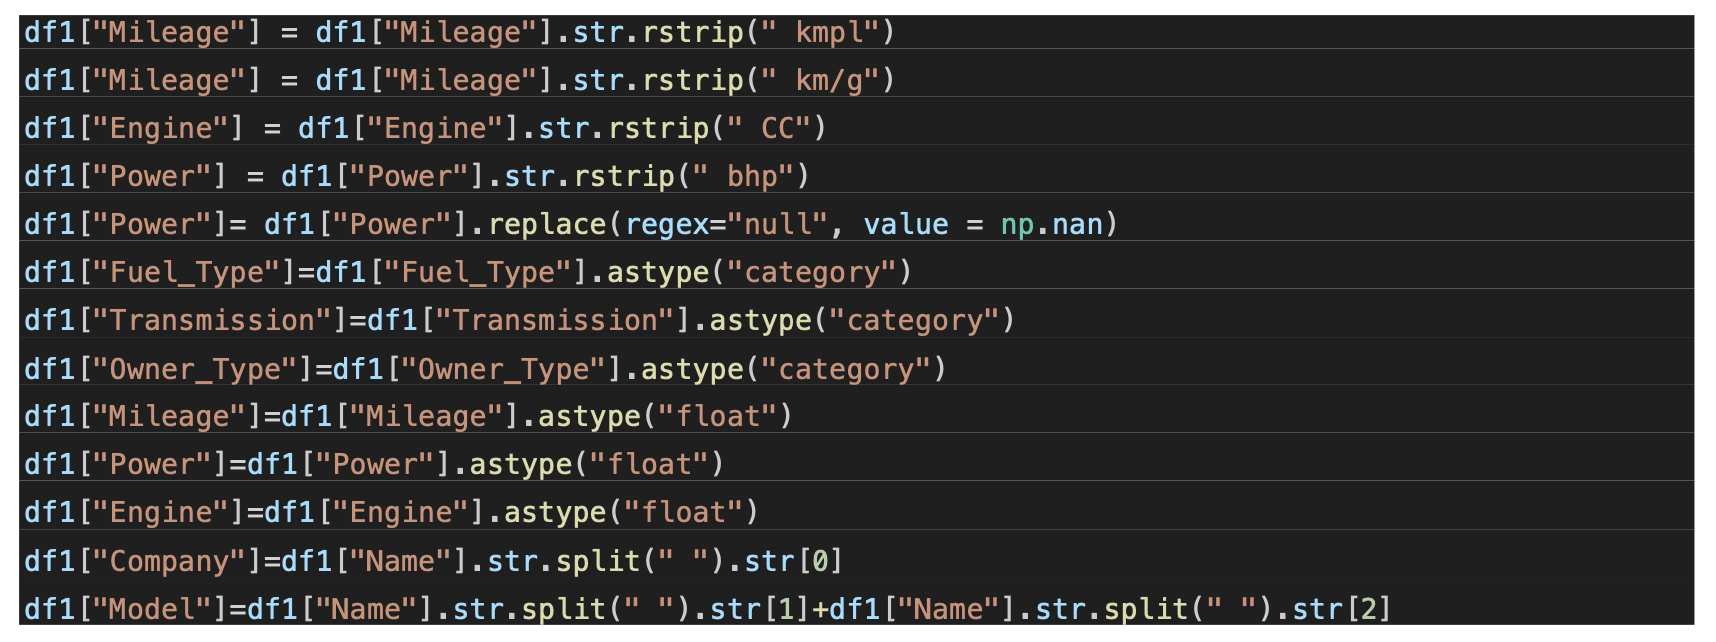

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.graphics.gofplots as sm
from sklearn.metrics import r2_score
from statsmodels.formula.api import ols
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

**1.Transform Price so that it looks more normal, produce histograms of the variable before and after transformation**

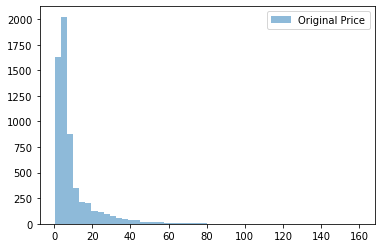

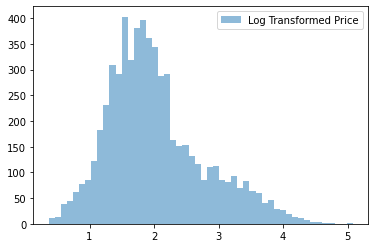

In [6]:
df1 = pd.read_csv("cars.csv")

# Original histogram
plt.hist(df1['Price'], bins=50, alpha=0.5, label='Original Price')
plt.legend(loc='upper right')
plt.show()

# Transform Price - Natural Log transformation is a common choice
df1['Log_Price'] = np.log1p(df1['Price'])

# Transformed histogram
plt.hist(df1['Log_Price'], bins=50, alpha=0.5, label='Log Transformed Price')
plt.legend(loc='upper right')
plt.show()

In [7]:
df1["Mileage"] = df1["Mileage"].str.rstrip(" kmpl")
df1["Mileage"] = df1["Mileage"].str.rstrip(" km/g")
df1["Engine"] = df1["Engine"].str.rstrip(" CC")
df1["Power"] = df1["Power"].str.rstrip(" bhp")
df1["Power"]= df1["Power"].replace(regex="null", value = np.nan)
df1["Fuel_Type"]=df1["Fuel_Type"].astype("category")
df1["Transmission"]=df1["Transmission"].astype("category")
df1["Owner_Type"]=df1["Owner_Type"].astype("category")
df1["Mileage"]=df1["Mileage"].astype("float")
df1["Power"]=df1["Power"].astype("float")
df1["Engine"]=df1["Engine"].astype("float")
df1["Company"]=df1["Name"].str.split(" ").str[0]
df1["Model"]=df1["Name"].str.split(" ").str[1]+df1["Name"].str.split(" ").str[2]

**2. How many values are missing for Power and Engine?**

In [8]:
missing_power = df1['Power'].isnull().sum()
missing_engine = df1['Engine'].isnull().sum()

print(f"Missing values for Power: {missing_power}")
print(f"Missing values for Engine: {missing_engine}")

Missing values for Power: 143
Missing values for Engine: 36


**3. Which column has the most missing values and what should we do about it?**

In [9]:
most_missing = df1.isnull().sum().idxmax()
print(f"Column with the most missing values: {most_missing}")

# Suggestion: drop:
df1.dropna(subset=[most_missing], inplace=True)

Column with the most missing values: New_Price


**4. Build a model of transformed price based on Power, Mileage, Kilometers Driven, and Year, how much variance is explained?**

In [10]:
Y = df1['Price']
lm = ols('Y ~ Power + Mileage + Kilometers_Driven + Year', data = df1).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     404.0
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          5.58e-192
Time:                        00:16:56   Log-Likelihood:                -2939.6
No. Observations:                 823   AIC:                             5889.
Df Residuals:                     818   BIC:                             5913.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2772.8048    302.56

By the R square value we know that 82% of the variance is explained by the model.

**5. How many rows were used to train the model?**

The number of observations indicates that 5874 rows are used to train the model. 

**6. Fill the missing values in Power and Mileage with their respective means and rebuild the model. Now how much variance is explained?**

In [11]:
df2 = df1.copy()
df2['Power'].fillna(df1['Power'].mean(), inplace=True)
df2['Mileage'].fillna(df1['Mileage'].mean(), inplace=True)
lm = ols('Price ~ Year + Kilometers_Driven + Mileage + Power', data=df2).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     401.9
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          1.86e-191
Time:                        00:16:58   Log-Likelihood:                -2944.4
No. Observations:                 824   AIC:                             5899.
Df Residuals:                     819   BIC:                             5922.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -2774.8010    303.023     -9.157      0.000   -3369.594   -2180.008
Year                  1.3705      0.150      9.134      0.000       1.076       1.665
Kilometers_Driven -2.384e-05   1.23e-05     -1.942      0.052   -4.79e-05    2.54e-07
Mileage               0.0681      0.079      0.867      0.386      -0.086       0.222
Power                 0.2113      0.006     32.685      0.000       0.199       0.224
==============================================================================
Omnibus:                      720.090   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75749.323
Skew:                           3.383   Prob(JB):                         0.00
Kurtosis:                      49.481   Cond. No.                     5.00e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  5e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**7. How many rows were used to train the model?**

The number of observations indicates that there are 6019 rows to be used to train the model. 

**8. Impute the missing data using MICE and rebuild the model**

In [12]:
df3 = pd.DataFrame({'Power': df1["Power"],'Mileage': df1["Mileage"], 'Kilometers_Driven': df1["Kilometers_Driven"], 'Year': df1["Year"]})
                  
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
X = imp.fit_transform(df3)

X = sm.add_constant(X)
y = df2['Price']
model = sm.OLS(y, X).fit()
print(model.summary())

[IterativeImputer] Completing matrix with shape (824, 4)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.01
[IterativeImputer] Change: 3.4899045102582207, scaled tolerance: 215.0 
[IterativeImputer] Early stopping criterion reached.
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     402.0
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          1.76e-191
Time:                        00:16:59   Log-Likelihood:                -2944.4
No. Observations:                 824   AIC:                             5899.
Df Residuals:                     819   BIC:                             5922.
Df Model:                           4                                         
Covariance Type:            nonrobust   

**9. How have the parameter estimates changed from step 4?**

The standard error of Mileage, Year and Kilometers Driven decreased from step4, while R^2 also decresed from 0.812 to 0.794.

**10. Plot the distribution of Power with and without MICE**

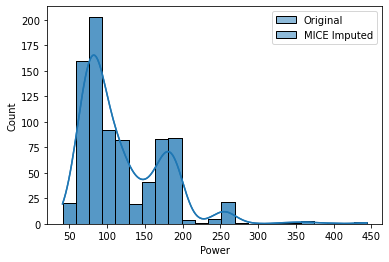

[IterativeImputer] Completing matrix with shape (824, 4)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.00
[IterativeImputer] Change: 8.299650606310202, scaled tolerance: 215.0 
[IterativeImputer] Early stopping criterion reached.
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     255.3
Date:                Thu, 26 Oct 2023   Prob (F-statistic):          2.47e-142
Time:                        00:17:01   Log-Likelihood:                -3058.4
No. Observations:                 824   AIC:                             6127.
Df Residuals:                     819   BIC:                             6150.
Df Model:                           4                                         
Covariance Type:            nonrobust    

In [13]:
# Without MICE
sns.histplot(df1['Power'], kde=True, label="Original")

# With MICE
sns.histplot(df2['Power'], kde=True, label="MICE Imputed")

plt.legend()
plt.show()

df4 = pd.DataFrame({'Mileage': df1["Mileage"],'Engine': df1["Engine"], 'Kilometers_Driven': df1["Kilometers_Driven"], 'Year': df1["Year"]})

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
X = imp.fit_transform(df4)

X = sm.add_constant(X)
y = df2['Price']
model = sm.OLS(y, X).fit()
print(model.summary())

**11. Plot the distribution of Engine with and without MICE**

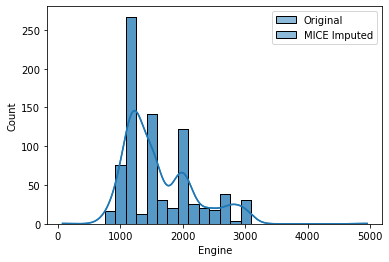

In [14]:
# Without MICE
sns.histplot(df1['Engine'], kde=True, label="Original")

# With MICE
sns.histplot(df2['Engine'], kde=True, label="MICE Imputed")

plt.legend()
plt.show()

# Section 2: Predicting customer spending

**We’ll be using the lab06_customers.csv data set for this lab. The data set covers the demographic characteristics of some customers and the amount they spent over the past year at an online retailer. For this exercise it is recommended to use the sklearn packages for linear regression, ridge, and lasso. Sklearn documentation linked below.**

Linear regression: https://scikitlearn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Ridge: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

**In order to interact the categorical variables you will need to dummy code them and manually multiply, an example is given below.**
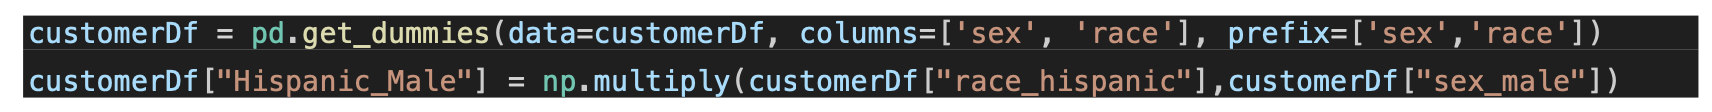

In [15]:
customer = pd.read_csv('lab06_customers.csv')

customer = pd.get_dummies(data=customer, columns=['sex', 'race'], prefix=['sex','race'])
customer["white_male"] = np.multiply(customer["race_white"],customer["sex_male"])
customer["white_female"] = np.multiply(customer["race_white"],customer["sex_female"])
customer["hispanic_male"] = np.multiply(customer["race_hispanic"],customer["sex_male"])
customer["hispanic_female"] = np.multiply(customer["race_hispanic"],customer["sex_female"])
customer["black_male"] = np.multiply(customer["race_black"],customer["sex_male"])
customer["black_female"] = np.multiply(customer["race_black"],customer["sex_female"])
customer["asian_male"] = np.multiply(customer["race_asian"],customer["sex_male"])
customer["asian_female"] = np.multiply(customer["race_asian"],customer["sex_female"])

customer.drop(columns = ['sex_other', 'race_other'], inplace = True)
customer['income']=np.log(customer['income'])
customer.head()

,income,schoolYears,age,spend,sex_female,sex_male,race_asian,race_black,race_hispanic,race_white,white_male,white_female,hispanic_male,hispanic_female,black_male,black_female,asian_male,asian_female
0,11.970135,18.0,31.0,659.97,0,1,0,0,0,1,1,0,0,0,0,0,0,0
1,9.317759,14.0,50.0,719.69,1,0,0,0,0,1,0,1,0,0,0,0,0,0
2,13.227388,14.0,32.0,854.61,0,1,0,0,1,0,0,0,1,0,0,0,0,0
3,12.514979,18.0,52.0,855.20,1,0,0,0,0,1,0,1,0,0,0,0,0,0
4,11.566078,17.0,49.0,758.33,1,0,0,0,0,1,0,1,0,0,0,0,0,0


**1. Build a linear regression with all the dependent variables and two way interactions between sex and race, consider the other category for race and sex to be the reference category and treat it appropriately**

In [16]:
X_interaction = customer.drop('spend', axis=1)
y_interaction = customer['spend']


X_train_interaction, X_test_interaction, y_train_interaction, y_test_interaction = train_test_split(X_interaction, y_interaction, test_size=0.2, random_state=42)


lr_interaction = LinearRegression()
lr_interaction.fit(X_train_interaction, y_train_interaction)


lr_interaction_preds = lr_interaction.predict(X_test_interaction)


lr_interaction_rmse = mean_squared_error(y_test_interaction, lr_interaction_preds, squared=False)

print(f'The result is {lr_interaction_rmse}.')

The result is 42.324889592254834.


**2. Build ridge models with various values for alpha. Create a chart showing how the coefficients change with alpha values**

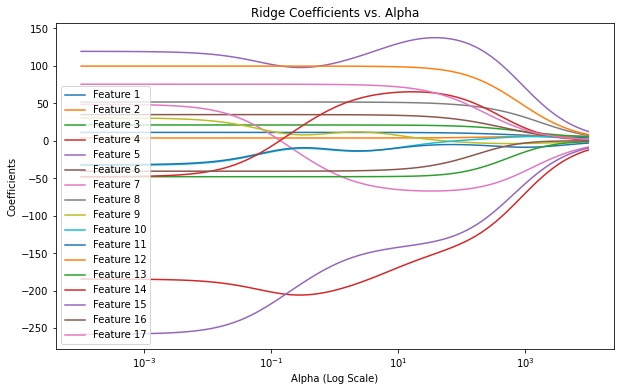

In [17]:
alphas = np.logspace(-4, 4, 100)

# Fit Ridge models and collect coefficients
coefficients = [Ridge(alpha=alpha).fit(X_train_interaction, y_train_interaction).coef_ for alpha in alphas]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the coefficients as a function of alpha for all features
for feature_coefficients in np.array(coefficients).T:
    ax.plot(alphas, feature_coefficients)

ax.set_xscale('log')  # Use a logarithmic scale for alpha

# Set labels and a title
ax.set_xlabel('Alpha (Log Scale)')
ax.set_ylabel('Coefficients')
ax.set_title('Ridge Coefficients vs. Alpha')

# Add a legend indicating the feature names or indices
ax.legend([f'Feature {i+1}' for i in range(len(coefficients[0]))])

# Display the plot
plt.show()

**3. Build lasso models with various values for alpha. Create a chart showing how the coefficients change with alpha values**

/Users/wry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6666691.301406407, tolerance: 10768.32832611414
  model = cd_fast.enet_coordinate_descent(
/Users/wry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6602957.468791121, tolerance: 10768.32832611414
  model = cd_fast.enet_coordinate_descent(
/Users/wry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6526400.27161627, tolerance: 10768.32832611414
  model = cd_fast.enet_coordinate_descent(
/Users/wry/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coord

NameError: name 'feature_names' is not defined

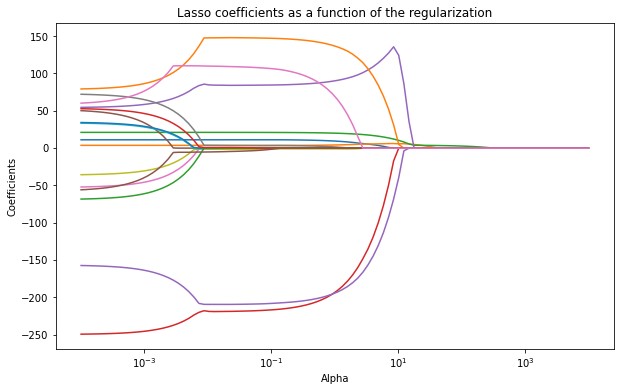

In [18]:
alphas = np.logspace(-4, 4, 100)
coefficients = []

coefficients_lasso = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train_interaction, y_train_interaction)
    coefficients_lasso.append(lasso.coef_)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefficients_lasso)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso coefficients as a function of the regularization')
plt.legend(feature_names, loc='upper right')
plt.axis('tight')
plt.show()

**4. Compare the coefficients from linear regression, ridge, and lasso (select an alpha value using your chart)**

In [38]:
feature_names = X_train_interaction.columns

lr_coefs = lr_interaction.coef_

ridge_alpha1 = Ridge(alpha=1)
lasso_alpha1 = Lasso(alpha=1)
ridge_alpha1.fit(X_train_interaction, y_train_interaction)
lasso_alpha1.fit(X_train_interaction, y_train_interaction)

ridge_coefs = ridge_alpha1.coef_
lasso_coefs = lasso_alpha1.coef_

coef_df = pd.DataFrame({'Feature': feature_names, 'Linear Regression': lr_coefs, 'Ridge': ridge_coefs, 'Lasso': lasso_coefs})

print('The comparisons are:\n', coef_df)

The comparisons are:
             Feature  Linear Regression       Ridge       Lasso
0            income          11.175474   11.164829    9.486583
1       schoolYears           3.737435    3.741175    4.225697
2               age          21.100589   21.069850   20.062694
3        sex_female        -184.473373 -199.522380 -193.413853
4          sex_male         119.355345  103.669975   90.141713
5        race_asian          34.923563   34.821960    0.000000
6        race_black          48.780959  -43.894470   -0.000000
7     race_hispanic          51.745705   51.680221    1.594914
8        race_white          30.584202   10.393868   -1.042490
9        white_male         -32.782776  -12.567439   -0.000000
10     white_female         -31.930410  -11.858332   -0.000000
11    hispanic_male          99.657349   99.570028  136.838345
12  hispanic_female         -47.911643  -47.889807   -0.000000
13       black_male         -48.052640   44.559673    0.000000
14     black_female        -258.1

**5. Compare the R2 from lr, ridge, and lasso**

In [34]:
lr_r2 = r2_score(y_test_interaction, lr_interaction_preds)

ridge_preds = ridge_alpha1.predict(X_test_interaction)
lasso_preds = lasso_alpha1.predict(X_test_interaction)

ridge_r2 = r2_score(y_test_interaction, ridge_preds)
lasso_r2 = r2_score(y_test_interaction, lasso_preds)

print(f'The results are {lr_r2, ridge_r2, lasso_r2}')

The results are (0.8664687546579961, 0.866510195701595, 0.8616542758917287)


**6. Which model would you choose, and why?**

I would choose the Ridge model as it has the highest R-squared score, which indicates that it explains the variance the best.

**7. Which variables are dropped from the chosen model that were not dropped in linear regression?**

Features from the Ridge model includes all the linear regression features, as Ridge regression does not typically set coefficients to zero unless the alpha parameter is extremely large, it tends to shrink the coefficients of less important features closer to zero vice versa.